In [ ]:
#Execute para habilitar a visualização de tabels dinâmicas
!pip install itables

In [ ]:
# @title
#execute para carregar o simulador

import pandas as pd
from io import StringIO
from bs4 import BeautifulSoup
import re
import numpy as np
from io import StringIO
from itables import init_notebook_mode

init_notebook_mode(all_interactive=True)

class Data:
    def __init__(self, demand_file_path, projects_file_path, curriculum_file_path, camaras_file_path):
        self.demand_file_path = demand_file_path
        self.projects_file_path = projects_file_path
        self.curriculum_file_path = curriculum_file_path
        self.camaras_file_path = camaras_file_path
        self.load_data()

    def load_data(self):
        self.demand_df = self.load_df_from_xlsx(self.demand_file_path)
        self.projects_df = self.load_df_from_xlsx(self.projects_file_path)
        self.curriculum_df = self.load_df_from_xlsx(self.curriculum_file_path)
        self.camaras_df = self.load_df_from_xlsx(self.camaras_file_path)
        assert self.curriculum_df is not None, "ERRO: Currículo não carregado"
        assert self.projects_df is not None, "ERRO: Projetos não carregados"
        assert self.demand_df is not None, "ERRO: Demanda não carregada"
        assert self.camaras_df is not None, "ERRO: Câmaras não carregadas"
        self.pre_process_curriculum()
        self.pre_process_demand()
        self.pre_process_projects()
        self.pre_process_camaras()

    def pre_process_camaras(self):
        df = self.camaras_df
        #print(df.to_string())

    def pre_process_curriculum(self):
        df = self.curriculum_df
        all_prereqs_list = df[~df['pre_requisitos'].isna()]['pre_requisitos'].str.cat(sep=';').split(';')
        unique_prereqs = set(all_prereqs_list)
        df['eh_pre_requisito'] = df['codigo'].isin(unique_prereqs)
        df['pratica'] = df['ch_pratica'] > 0
        df['ch_teorica'] = df['ch_total']-df['ch_pratica']
        #print(self.curriculum_df)

    def pre_process_projects(self):
        df = self.projects_df
        df['docente_ne'] = df['docente_ne']=="sim"
        #print(df)

    def pre_process_demand(self):
        df = self.demand_df
        #print(df)

    def load_df_from_xlsx(self, file_path):
        try:
            df = pd.read_excel(file_path)
            return df
        except FileNotFoundError:
            print(f"ERRO: O arquivo '{file_path}' não foi encontrado.")
            print("Por favor, verifique se o nome e o caminho do arquivo estão corretos.")
        except Exception as e:
            print(f"Ocorreu um erro inesperado durante o processamento: {e}")
        return None

    def get_demand_by_area(self, use_elective=False):
        df_per_component = self.get_demand_by_component(use_elective=use_elective)
        numeric_columns_to_sum = [
            'matriculados', 'n_turmas', 'n_subturmas',
            'ch_teorica', 'ch_pratica', 'ch_total', 'pre_requisito', "n_componentes"
        ]
        agg_dict = {col: 'sum' for col in numeric_columns_to_sum if col in df_per_component.columns}
        if 'n_professores' in df_per_component.columns:
            agg_dict['n_professores'] = 'first'

        df_by_area = df_per_component.groupby('camara').agg(agg_dict).reset_index()
        df_by_area = df_by_area.rename(columns={'camara': 'titulo'})
        self.__add_proportions(df_by_area)
        df_by_area = df_by_area.sort_values(by='matriculados', ascending=False)
        return df_by_area

    def __add_proportions(self, df):
        global_demand = df['matriculados'].sum()
        if global_demand > 0:
            df['prop_matriculados'] = df['matriculados'] / global_demand
        else:
            df['prop_matriculados'] = 0
        global_ch= df['ch_total'].sum()
        if global_demand > 0:
            df['prop_ch_total'] = df['ch_total'] / global_ch
        else:
            df['prop_ch_total'] = 0
        df['prop_pre_requisito'] = df['pre_requisito']/self.curriculum_df['codigo'].count()
        df['prop_forca_trabalho'] = df['n_professores']/self.camaras_df['n_professores'].sum()

    def get_demand_by_component(self, use_elective=False):
        demand_df = self.demand_df.copy()
        demand_df['turma_principal'] = demand_df['turma'].astype(str).str.extract(r'(\d+)').fillna('0')
        target_demand_df = demand_df
        if not use_elective:
            curriculum_codes = self.curriculum_df['codigo'].unique()
            target_demand_df = demand_df[demand_df['codigo'].isin(curriculum_codes)].copy()
        curriculum_info = self.curriculum_df[['codigo', 'nome', 'camara', 'ch_teorica', 'ch_pratica']].drop_duplicates(subset=['codigo'])
        demand_with_info = pd.merge(
            target_demand_df,
            curriculum_info,
            on='codigo',
            how='left'
        )
        demand_with_info['nome'] = np.where(
            demand_with_info['nome_y'].notna(),
            demand_with_info['nome_y'],
            demand_with_info['nome_x']
        )
        demand_with_info.drop(columns=['nome_x', 'nome_y'], inplace=True)
        demand_with_info[['ch_teorica', 'ch_pratica']] = demand_with_info[['ch_teorica', 'ch_pratica']].fillna(0)
        demand_with_info['camara'] = demand_with_info['camara'].fillna('Não definida')
        def aggregate_component(group):
            # ... (esta função interna permanece a mesma) ...
            matriculados = group['matriculados'].sum()
            n_turmas = group.drop_duplicates(subset=['periodo', 'turma_principal']).shape[0]
            grupo_pratico = group[group['ch_pratica'] > 0]
            n_subturmas = grupo_pratico.drop_duplicates(subset=['periodo', 'turma']).shape[0]
            ch_teorica_base = group['ch_teorica'].iloc[0] if not group.empty else 0
            ch_pratica_base = group['ch_pratica'].iloc[0] if not group.empty else 0
            ch_teorica_total = n_turmas * ch_teorica_base
            ch_pratica_total = n_subturmas * ch_pratica_base
            return pd.Series({
                'matriculados': matriculados,
                'n_turmas': n_turmas,
                'n_subturmas': n_subturmas,
                'ch_teorica': ch_teorica_total,
                'ch_pratica': ch_pratica_total
            })
        summary_df = demand_with_info.groupby(
            ['codigo', 'nome', 'camara'],
        ).apply(aggregate_component,  include_groups=False).reset_index()
        summary_df = summary_df.rename(columns={'nome': 'titulo'})
        int_columns = ['matriculados', 'n_turmas', 'n_subturmas', 'ch_teorica', 'ch_pratica']
        summary_df[int_columns] = summary_df[int_columns].astype(int)
        summary_df.loc[summary_df['ch_teorica'] == 0, 'n_turmas'] = 0
        summary_df = summary_df.sort_values(by='matriculados', ascending=False)
        summary_df['ch_total'] = summary_df['ch_teorica'] + summary_df['ch_pratica']
        summary_df = summary_df.sort_values(by='matriculados', ascending=False)
        all_prereqs = self.curriculum_df['pre_requisitos'].dropna().str.split(';').explode()
        prereq_counts = all_prereqs.value_counts()
        summary_df['pre_requisito'] = summary_df['codigo'].map(prereq_counts).fillna(0).astype(int)
        summary_df = pd.merge(summary_df, self.camaras_df, on='camara', how='left')
        summary_df['n_professores'] = summary_df['n_professores'].fillna(0).astype(int)
        summary_df['n_componentes'] = 1
        self.__add_proportions(summary_df)
        return summary_df

class Components:

    def __init__(self, *files):
        self.files = files
        self.df_list = []
        self.stacked_df = None
        self.load_data()
        self.stack_dataframes()

    def load_data(self):
        for file in self.files:
            self.read_file(file)

    def stack_dataframes(self):
        self.stacked_df = pd.concat(self.df_list, ignore_index=True)

    def save_to_excel(self, output_filename):
        if self.stacked_df is None:
            self.stack_dataframes()
        if self.stacked_df is None or self.stacked_df.empty:
            return
        try:
            self.stacked_df.to_excel(output_filename, index=False)
        except Exception as e:
            print(f"Ocorreu um erro ao salvar o arquivo Excel: {e}")

    def read_file(self, file):
        try:
            #print(f"Lendo: {file}")
            with open(file, 'r', encoding='utf-8') as f:
                html_content = f.read()
            lista_de_dataframes = pd.read_html(StringIO(html_content), header=0)
            tabelas_de_disciplinas = []
            for df_tabela in lista_de_dataframes:
                if 'Cod. Comp.' in df_tabela.columns:
                    tabelas_de_disciplinas.append(df_tabela)
            df_completo = pd.concat(tabelas_de_disciplinas, ignore_index=True)
            column_mapping = {
                'Cod. Comp.': 'codigo',
                'Nome Componente': 'nome',
                'Turma': 'turma',
                'Horário': 'horario',
                'Cap': 'capacidade',
                'Mat': 'matriculados'
            }
            df_selecionado = df_completo[list(column_mapping.keys())].copy()
            df_selecionado['Cap'] = pd.to_numeric(df_selecionado['Cap'], errors='coerce').fillna(0).astype(int)
            df_selecionado['Mat'] = pd.to_numeric(df_selecionado['Mat'], errors='coerce').fillna(0).astype(int)
            df_selecionado['Horário'] = df_selecionado['Horário'].fillna('')
            periodo = re.search(r'(\d{4}-\d)', file).group(1) if re.search(r'(\d{4}-\d)', file) else 'unknown'
            df_selecionado['periodo'] = periodo
            df_renomeado = df_selecionado.rename(columns=column_mapping)
            df_final = df_renomeado[df_renomeado['codigo'].str.startswith('ECT')].copy()
            self.df_list.append(df_final)
        except FileNotFoundError:
            print(f"ERRO: O arquivo '{file}' não foi encontrado.")
            print("Por favor, verifique se o nome e o caminho do arquivo estão corretos.")
        except Exception as e:
            print(f"Ocorreu um erro inesperado durante o processamento: {e}")

class Curriculum(Components):
    def read_file(self, file):
        try:
            #print(f"Lendo: {file}")
            with open(file, 'r', encoding='utf-8') as f:
                text_content = f.read()
            blocos_periodo = re.split(r'\n(?=\d+°? PERÍODO)', text_content.strip())
            lista_de_disciplinas = []
            for bloco in blocos_periodo:
                if not bloco.strip():
                    continue
                match_periodo = re.search(r'(\d+)°? PERÍODO', bloco)
                if not match_periodo:
                    continue
                periodo = int(match_periodo.group(1))
                linhas_disciplina = re.findall(r'^(ECT\d{4})\s+(.+?)\s+(\d+)$', bloco, re.MULTILINE)
                for codigo, nome, carga_horaria in linhas_disciplina:
                    lista_de_disciplinas.append({
                        'periodo': periodo,
                        'codigo': codigo,
                        'nome': nome.strip(),
                        'carga_horaria': int(carga_horaria)
                    })
            if not lista_de_disciplinas:
                return
            df_final = pd.DataFrame(lista_de_disciplinas)
            self.df_list.append(df_final)
        except FileNotFoundError:
            print(f"ERRO: O arquivo '{file}' não foi encontrado.")
        except Exception as e:
            print(f"Ocorreu um erro inesperado ao processar o currículo de texto: {e}")

class Simulator:

    def __init__(self, data, weights=None):
        self.data = data
        self.weights = weights

    def simulate_by_component(self, index_function, total, use_elective=False, min_by_project=0, xlsx_output_file=None):
        df = self.data.get_demand_by_component(use_elective)
        df = index_function(df)
        df = self.distribute(df, total, "IP", min_by_project)
        self.__write_xlsx(df, xlsx_output_file)
        #print(df.to_string())
        return df
        #df.info()

    def simulate_by_area(self, index_function, total, use_elective=False, min_by_project=0, xlsx_output_file=None):
        df = self.data.get_demand_by_area(use_elective)
        df = index_function(df)
        df = self.distribute(df, total, "IP", min_by_project)
        #print(df.to_string())
        self.__write_xlsx(df, xlsx_output_file)
        return df
        #df.info()

    def simulate_by_area_and_practice(self, index_function, total, use_elective=False, min_by_project=0, xlsx_output_file=None):
        df = self.simulate_by_component_and_practice(index_function, total, use_elective=use_elective, min_by_project=min_by_project, xlsx_output_file=xlsx_output_file)
        numeric_columns_to_sum = [
            'matriculados', 'n_turmas', 'n_subturmas',
            'ch_teorica', 'ch_pratica', 'ch_total', 'pre_requisito', "n_componentes", "bolsas_total"
        ]
        agg_dict = {col: 'sum' for col in numeric_columns_to_sum if col in df.columns}
        if 'n_professores' in df.columns:
            agg_dict['n_professores'] = 'first'
        df = df.groupby('camara').agg(agg_dict).reset_index()
        #print(df.to_string())
        df = df.rename(columns={'camara': 'titulo'})
        self.__write_xlsx(df, xlsx_output_file)
        return df

    def simulate_by_component_and_practice(self, index_function, total, use_elective=False, min_by_project=0, xlsx_output_file=None):
        df = self.data.get_demand_by_component(use_elective)
        df = index_function(df)
        df, remaining = self.distribute_by_practice(df, total)
        df = self.distribute(df, remaining, "IP", min_by_project)
        #print(df.to_string())
        self.__write_xlsx(df, xlsx_output_file)
        return df

    def __write_xlsx(self, df, xlsx_output_file=None):
        if xlsx_output_file is not None:
            df.to_excel(xlsx_output_file)

    def distribute_by_practice(self, df, total):
        df['bolsas_pratica'] = df['ch_pratica']/30/10
        df['bolsas_pratica'] = df['bolsas_pratica'].apply(np.ceil).astype(int)
        total -= int(df['bolsas_pratica'].sum())
        return df, total

    def distribute(self, df, total_bolsas, coluna_indice, min_by_project=0):
        df_result = df
        soma_total_indice = df_result[coluna_indice].sum()
        df_result['bolsas_total'] = 0
        if total_bolsas > df_result.shape[0]:
            df_result['bolsas_total'] = df_result['n_componentes']
        total_bolsas -= df_result['bolsas_total'].sum()

        if soma_total_indice == 0:
            df_result['bolsas_total'] = 0
            return df_result
        df_result['proporcao'] = df_result[coluna_indice] / soma_total_indice
        df_result['alocacao_ideal'] = df_result['proporcao'] * total_bolsas
        df_result['alocacao_base'] = df_result['alocacao_ideal'].apply(np.floor).astype(int)
        df_result['residuo'] = df_result['alocacao_ideal'] - df_result['alocacao_base']
        bolsas_alocadas_base = df_result['alocacao_base'].sum()
        bolsas_restantes = total_bolsas - bolsas_alocadas_base
        df_result['bolsas_total'] = df_result['bolsas_total']+ df_result['alocacao_base']
        if bolsas_restantes > 0:
            indices_maiores_residuos = df_result['residuo'].nlargest(bolsas_restantes).index
            df_result.loc[indices_maiores_residuos, 'bolsas_total'] += 1
        df_result.drop(columns=['proporcao', 'alocacao_ideal', 'alocacao_base', 'residuo'], inplace=True)
        if 'bolsas_pratica' in df_result.columns:
            df_result['bolsas_teorica'] = df['bolsas_total']
            df_result['bolsas_total'] = df_result['bolsas_total'] + df_result['bolsas_pratica']
            colunas = list(df.columns)
            colunas[colunas.index("bolsas_total")], colunas[colunas.index("bolsas_teorica")] = "bolsas_teorica", "bolsas_total"
            df_result = df_result[colunas]
        return df_result

# Modelos para Alocação de Bolsas de Monitoria

1. Dados da demanda 2024.2 e 2025.1;
2. Sugestão de método de alocação baseado em índice de prioridade;
3. Disciplinas obrigatórias do BCT (generalista);
4. Calcular bolsas com base em componentes para atribuir cotas às Câmara.
5. Câmara poderia decidir para quais componentes e em que quantidade faria essa distribuição;
6. Uma fração das bolsas não seria utilizada no processo de distribuição, dando autonomia para a direção fazer uma alocação estratégia ou suprir outras necessidades.  

O termo **item** será utilizado para se referir tanto a um **componente curricular** (disciplina) quanto a uma **câmara temática** (agrupamento de componentes).

> Dados em https://drive.google.com/drive/folders/12S1l-m0ICj2SSHune8_9qEtBHUSe5CwI?usp=sharing


# Visualização de Dados

In [ ]:
"""
Execute o código abaixo para baixar e abrir os arquivos de dados,
trazendo estes dados do GoogleDrive da Comissão para este Colab
"""

!gdown 1TL3vTGzoMCeIxieZAng1ylMd0992F4fn
!gdown 1FvXGlXiaGJIFhlI_P5CErMGxoaB5KIPH
!gdown 12VkSiF9jQz73WUEckh7eLnp_qu--Ny4j
!gdown 1FFKQYCrjOdDymwCaQ6AMRAPs1usiXFoz

data = Data(curriculum_file_path="curriculo.xlsx",
            demand_file_path="demanda.xlsx",
            projects_file_path="projetos.xlsx",
            camaras_file_path="camaras.xlsx"
)

Downloading...
From: https://drive.google.com/uc?id=1TL3vTGzoMCeIxieZAng1ylMd0992F4fn
To: /content/camaras.xlsx
100% 34.6k/34.6k [00:00<00:00, 23.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1FvXGlXiaGJIFhlI_P5CErMGxoaB5KIPH
To: /content/curriculo.xlsx
100% 22.2k/22.2k [00:00<00:00, 36.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=12VkSiF9jQz73WUEckh7eLnp_qu--Ny4j
To: /content/demanda.xlsx
100% 28.4k/28.4k [00:00<00:00, 18.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1FFKQYCrjOdDymwCaQ6AMRAPs1usiXFoz
To: /content/projetos.xlsx
100% 10.9k/10.9k [00:00<00:00, 19.7MB/s]


In [ ]:
#Execute para ver as câmaras baixadas
data.camaras_df

Loading ITables v2.5.2 from the internet... (need help?)


In [ ]:
#Execute para ver o curriculo baixado
data.curriculum_df

Loading ITables v2.5.2 from the internet... (need help?)


In [ ]:
#Execute para ver a oferta de turmas baixada
data.demand_df

Loading ITables v2.5.2 from the internet... (need help?)


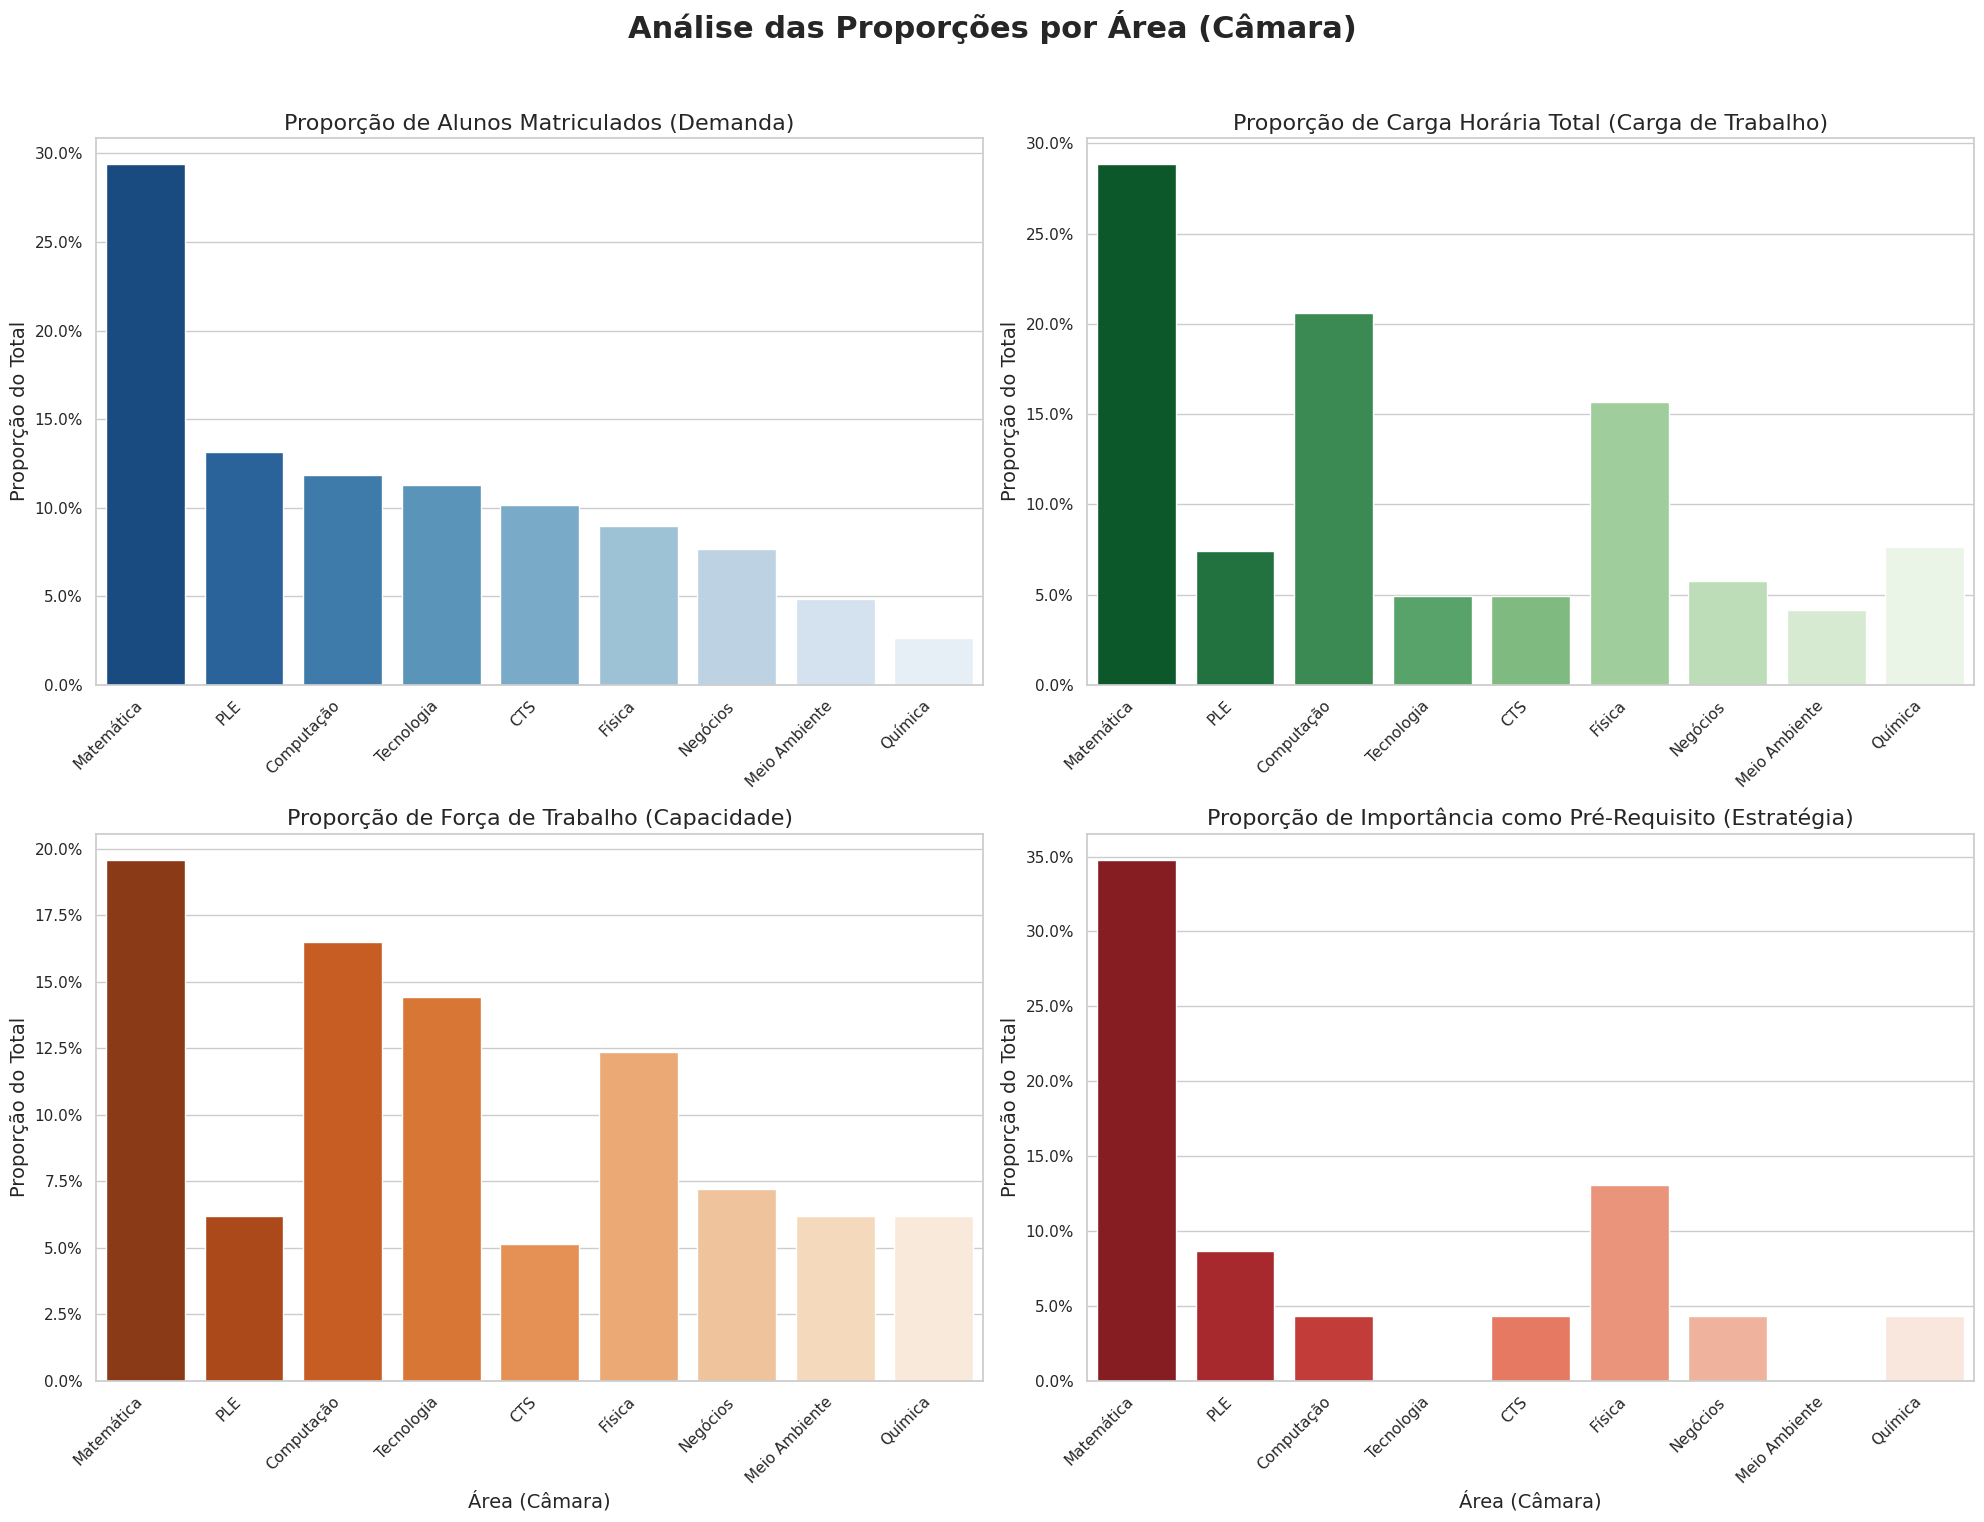

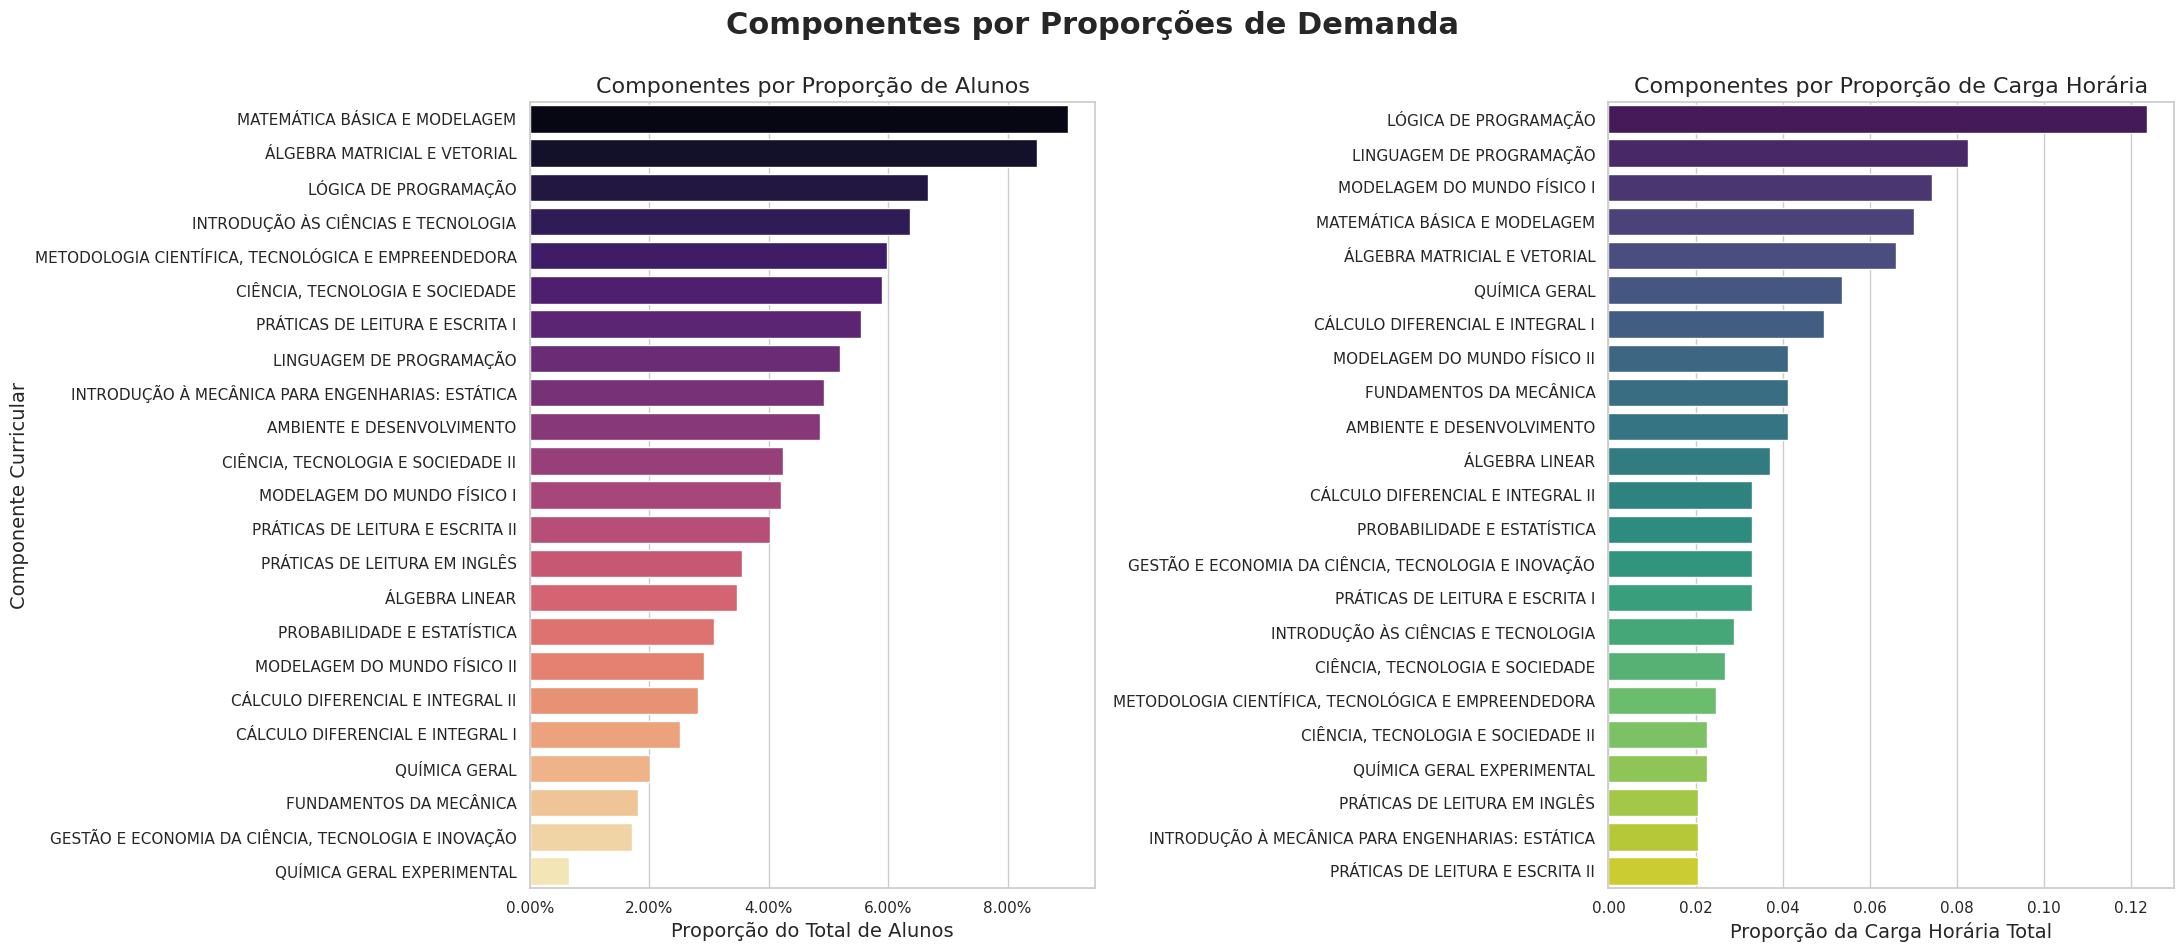

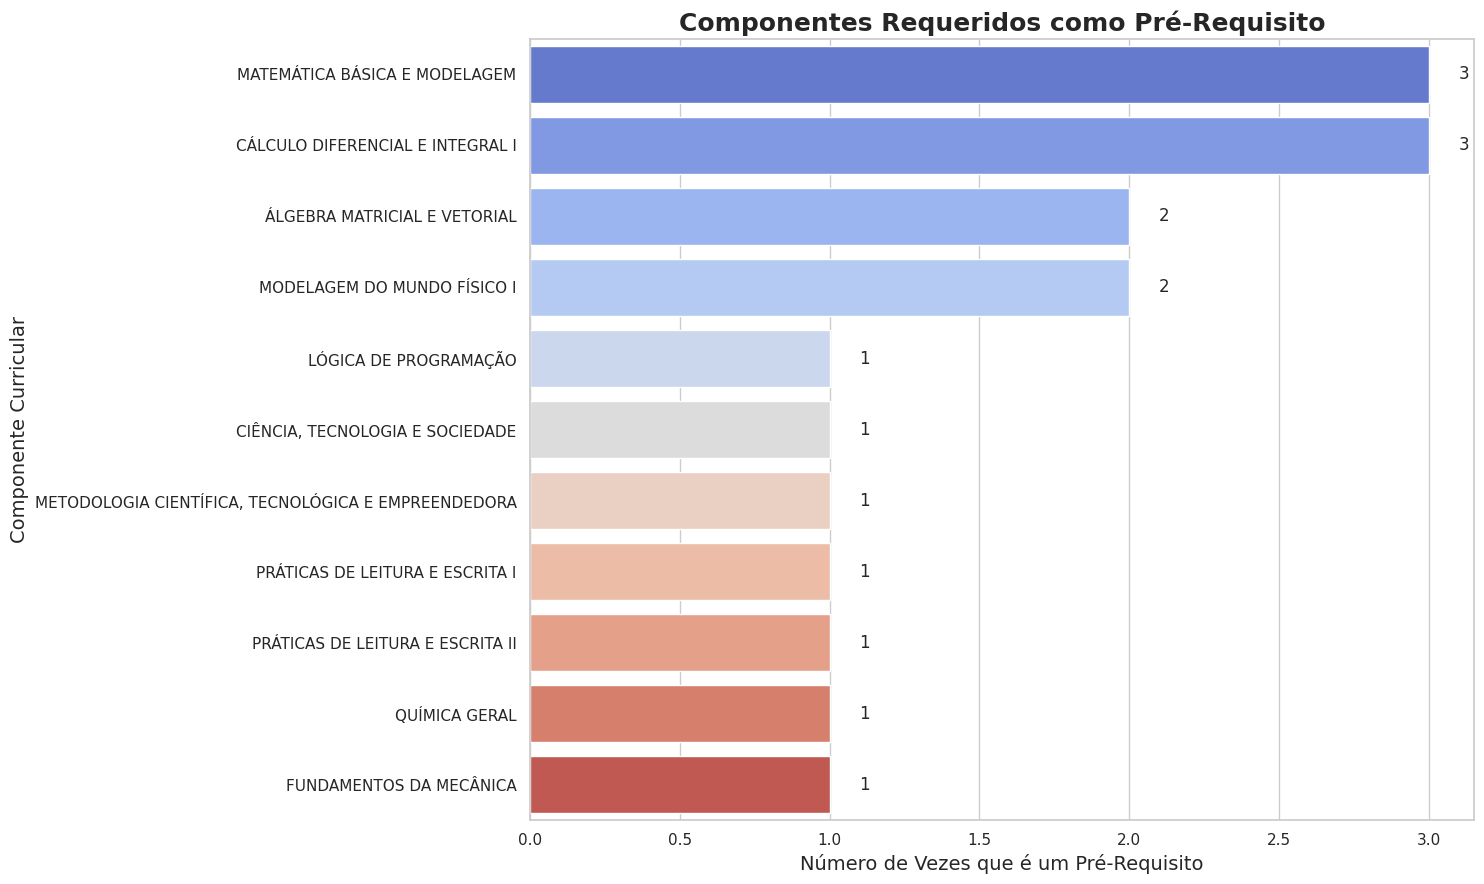

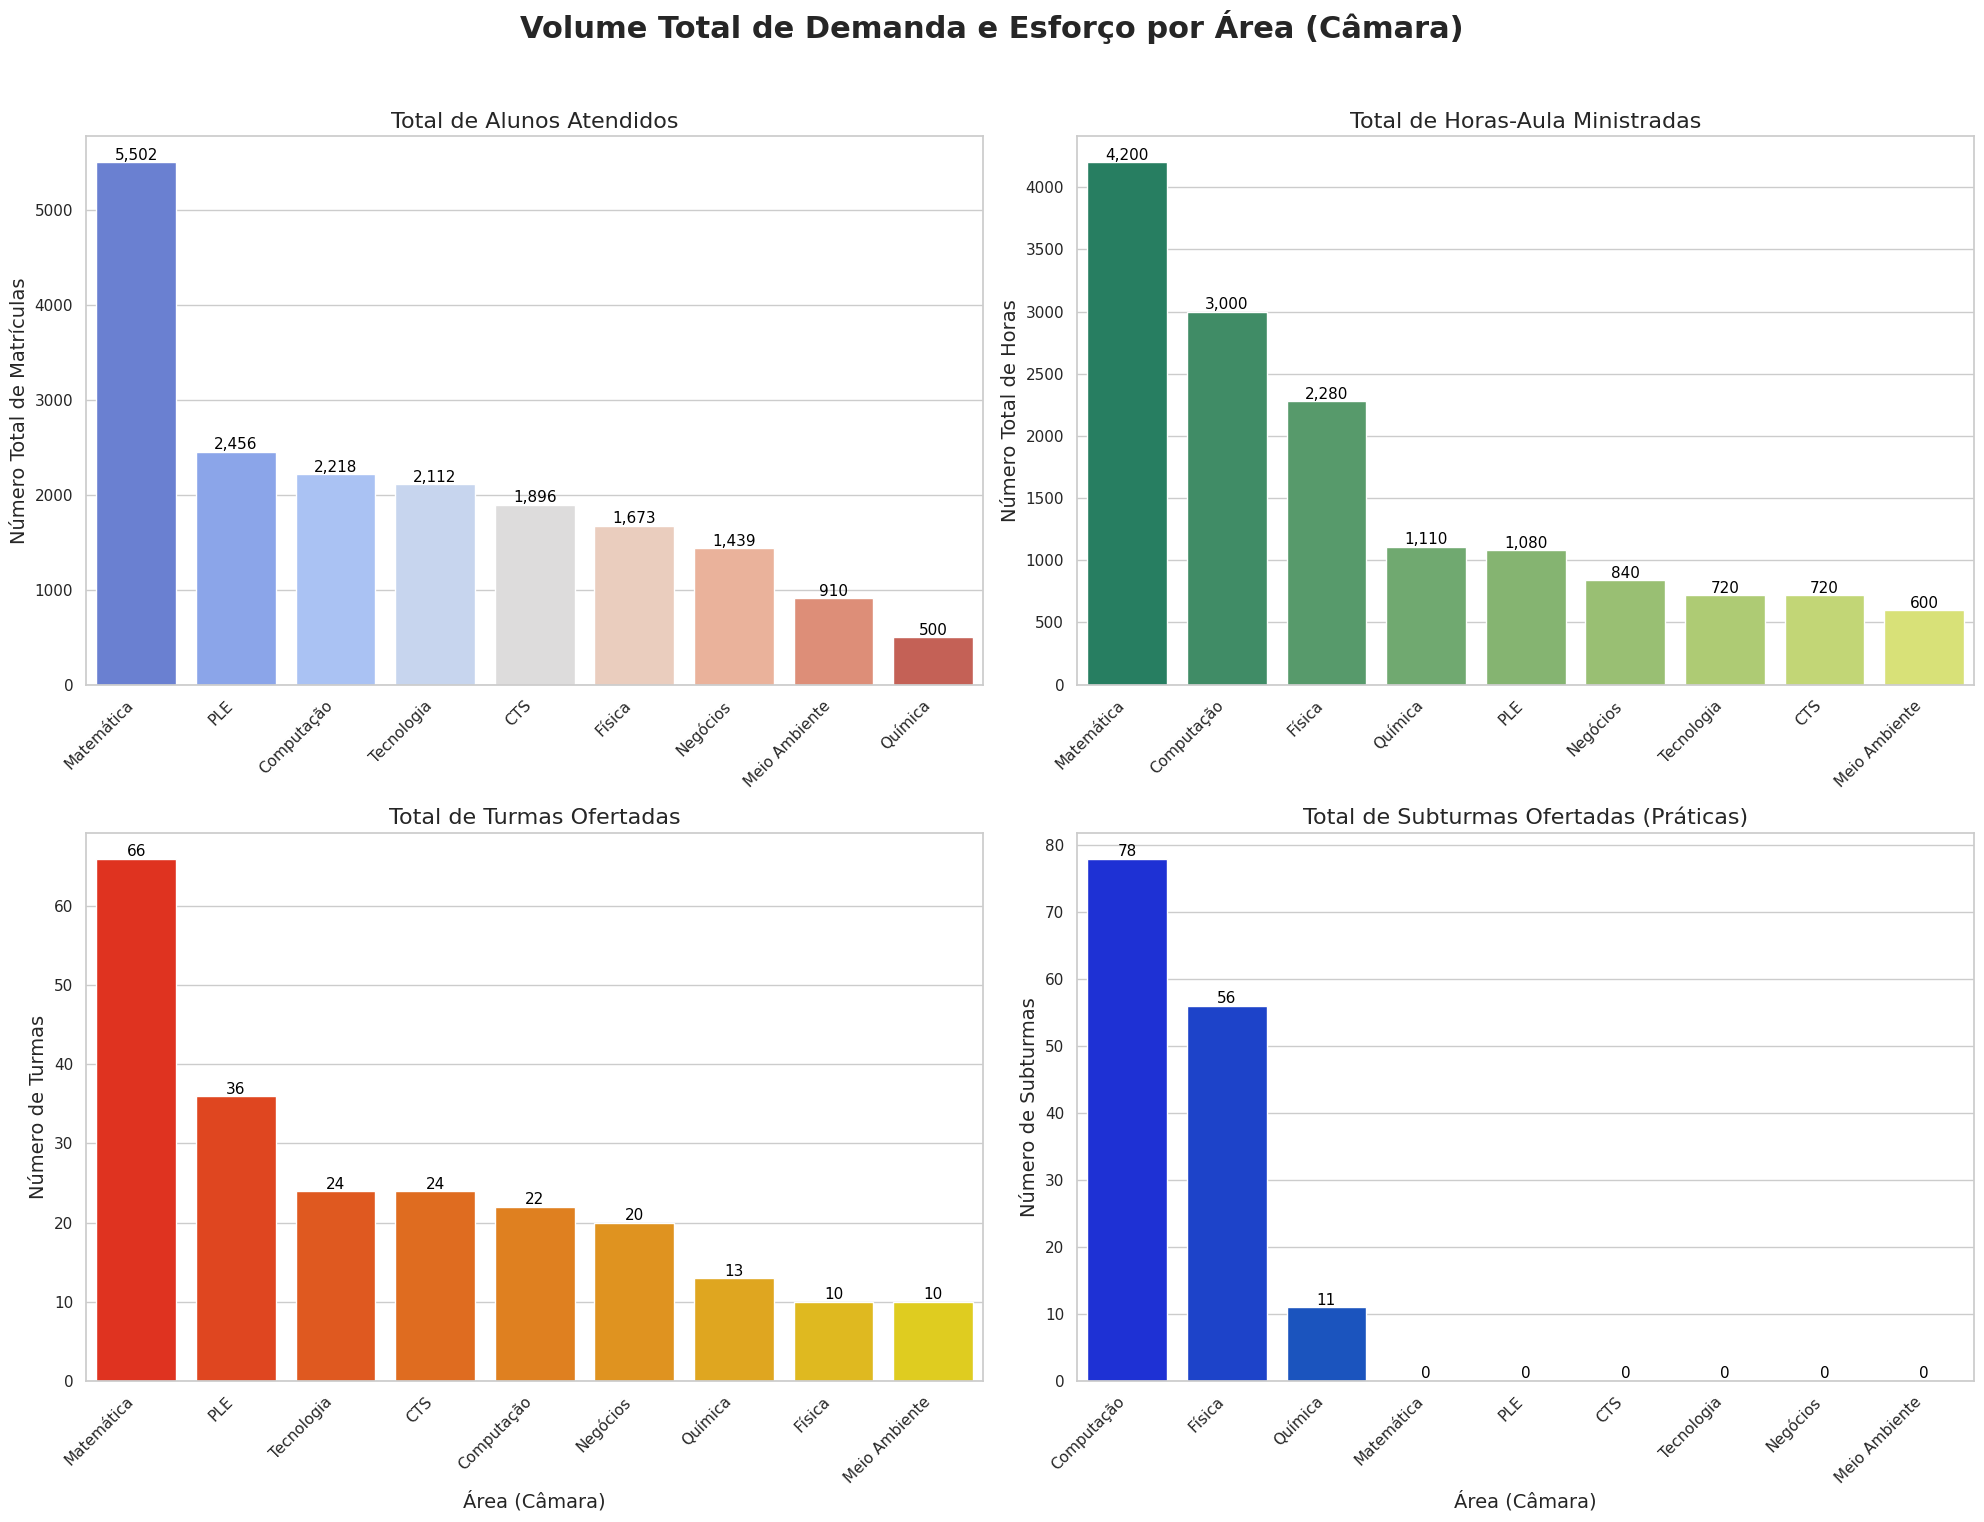

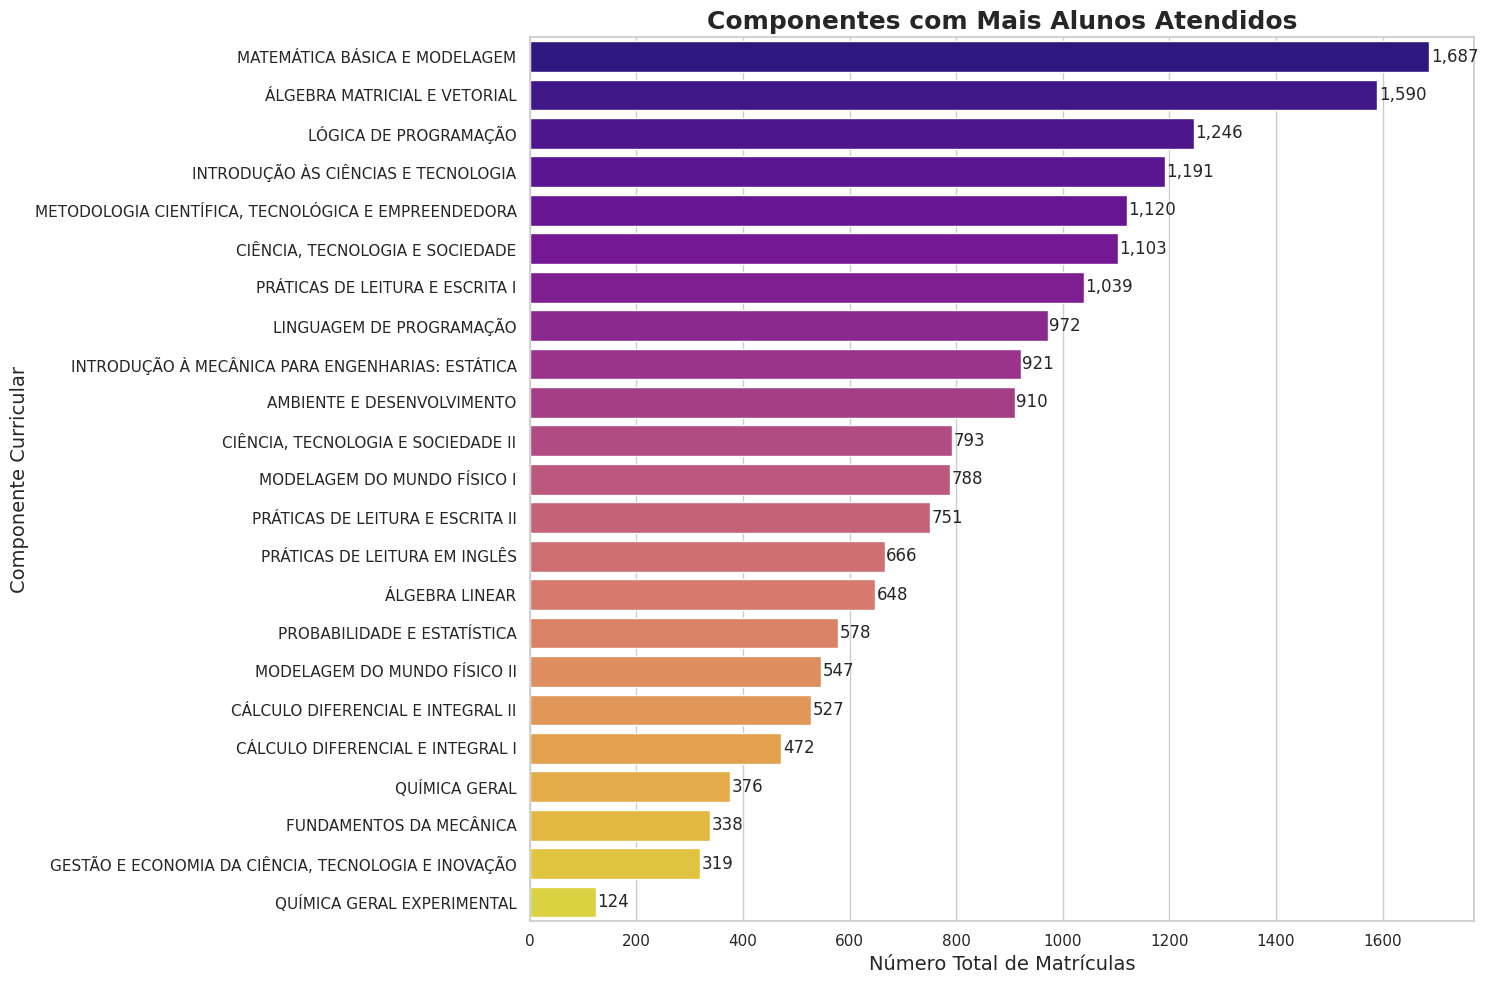

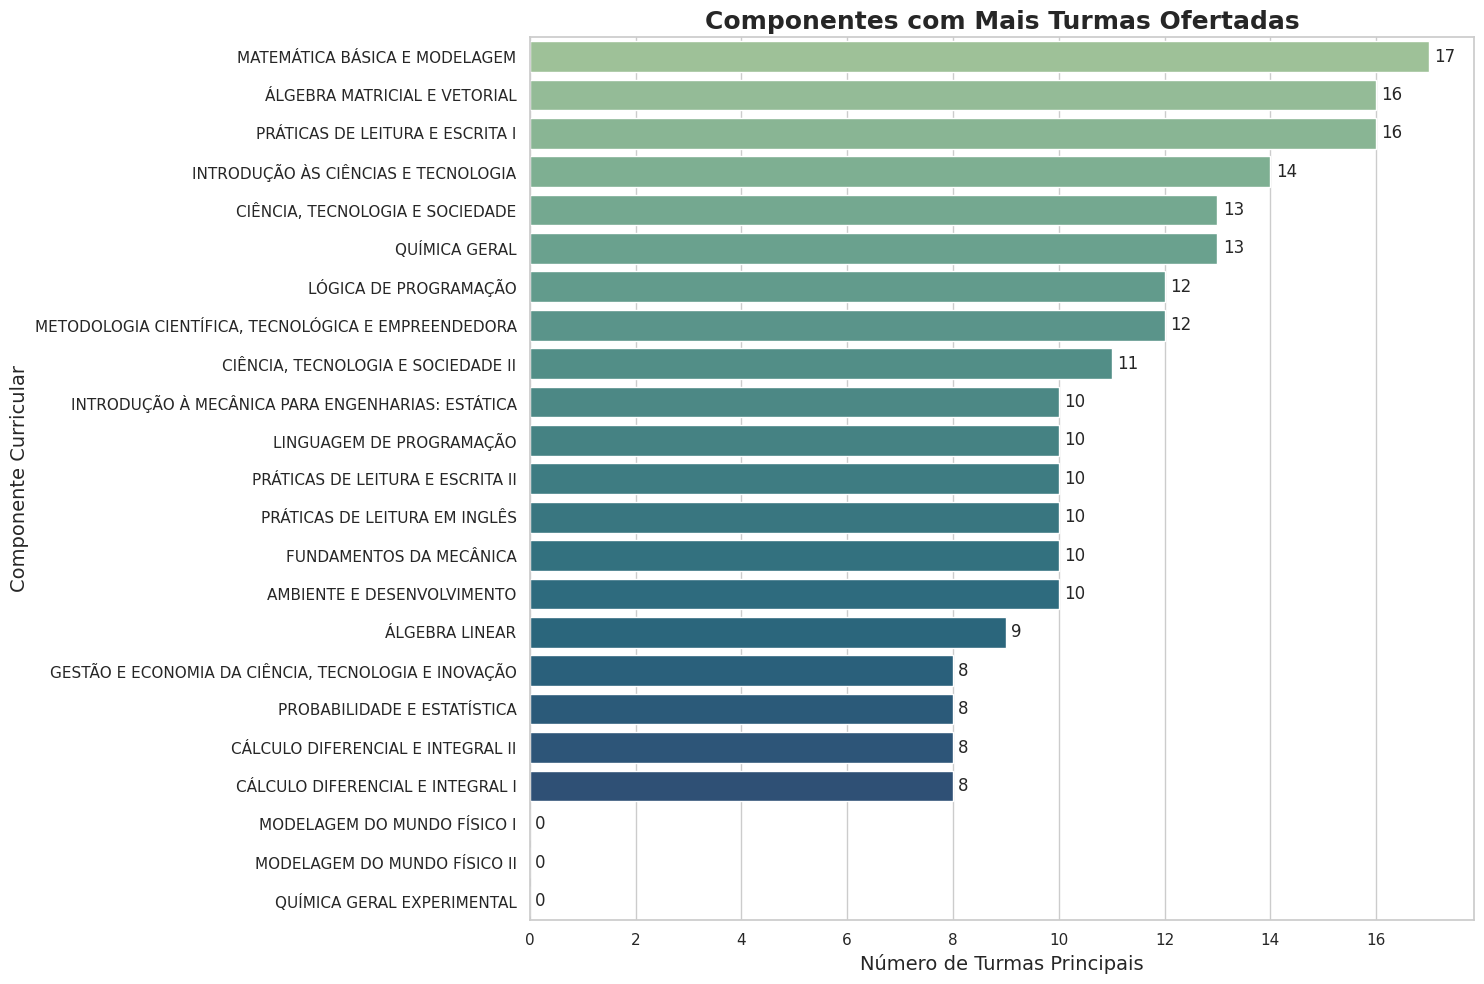

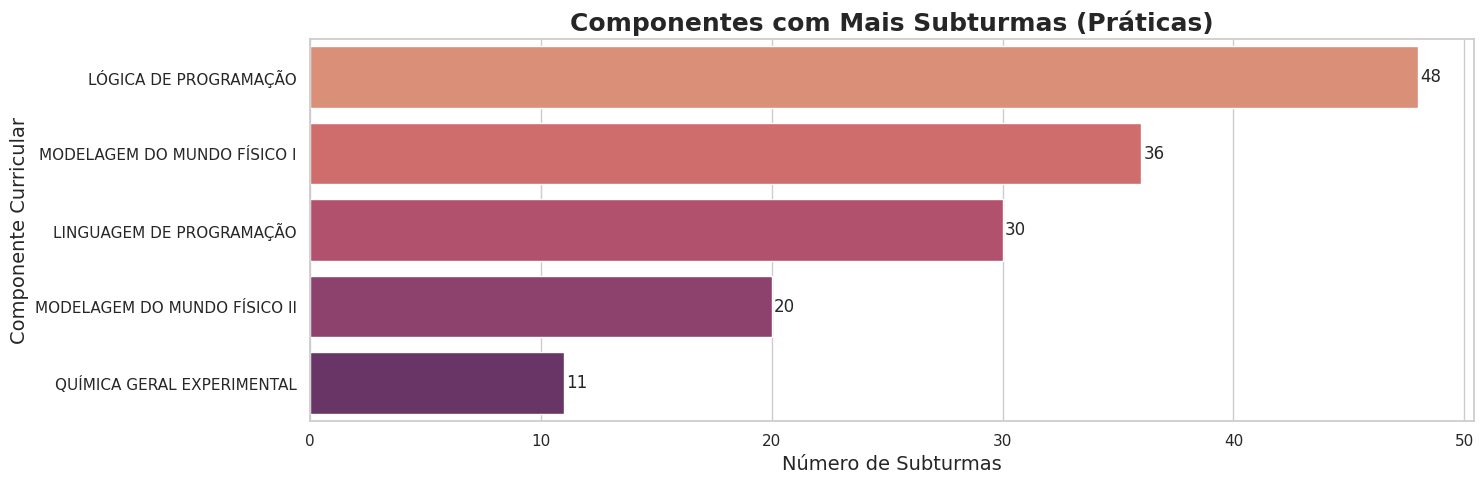

In [ ]:
#Visualizar dados
import matplotlib.pyplot as plt
import seaborn as sns

# =============================================================================
# SETUP E CARREGAMENTO DE DADOS
# =============================================================================
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

df_area = data.get_demand_by_area(use_elective=False)
df_componente = data.get_demand_by_component(use_elective=False)

# =============================================================================
# GRÁFICOS DE ANÁLISE DE PROPORÇÕES
# =============================================================================

# --- Proporções por Área (Câmara) ---
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Análise das Proporções por Área (Câmara)', fontsize=22, weight='bold')

sns.barplot(ax=axes[0, 0], data=df_area, x='titulo', y='prop_matriculados', palette='Blues_r', hue='titulo', legend=False)
axes[0, 0].set_title('Proporção de Alunos Matriculados (Demanda)', fontsize=16)
axes[0, 0].set_xlabel('')
axes[0, 0].set_ylabel('Proporção do Total', fontsize=14)

sns.barplot(ax=axes[0, 1], data=df_area, x='titulo', y='prop_ch_total', palette='Greens_r', hue='titulo', legend=False)
axes[0, 1].set_title('Proporção de Carga Horária Total (Carga de Trabalho)', fontsize=16)
axes[0, 1].set_xlabel('')
axes[0, 1].set_ylabel('Proporção do Total', fontsize=14)

sns.barplot(ax=axes[1, 0], data=df_area, x='titulo', y='prop_forca_trabalho', palette='Oranges_r', hue='titulo', legend=False)
axes[1, 0].set_title('Proporção de Força de Trabalho (Capacidade)', fontsize=16)
axes[1, 0].set_xlabel('Área (Câmara)', fontsize=14)
axes[1, 0].set_ylabel('Proporção do Total', fontsize=14)

sns.barplot(ax=axes[1, 1], data=df_area, x='titulo', y='prop_pre_requisito', palette='Reds_r', hue='titulo', legend=False)
axes[1, 1].set_title('Proporção de Importância como Pré-Requisito (Estratégia)', fontsize=16)
axes[1, 1].set_xlabel('Área (Câmara)', fontsize=14)
axes[1, 1].set_ylabel('Proporção do Total', fontsize=14)

for ax in axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

# --- Proporções por Componente (Todos) ---
num_componentes = len(df_componente)
altura_dinamica_1 = max(10, num_componentes * 0.4)

fig, axes = plt.subplots(1, 2, figsize=(22, altura_dinamica_1))
fig.suptitle('Componentes por Proporções de Demanda', fontsize=22, weight='bold')

df_sorted_mat = df_componente.sort_values('prop_matriculados', ascending=False)
sns.barplot(ax=axes[0], data=df_sorted_mat, y='titulo', x='prop_matriculados', palette='magma', hue='titulo', legend=False)
axes[0].set_title('Componentes por Proporção de Alunos', fontsize=16)
axes[0].set_xlabel('Proporção do Total de Alunos', fontsize=14)
axes[0].set_ylabel('Componente Curricular', fontsize=14)
axes[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.2%}'.format(x)))

df_sorted_ch = df_componente.sort_values('prop_ch_total', ascending=False)
sns.barplot(ax=axes[1], data=df_sorted_ch, y='titulo', x='prop_ch_total', palette='viridis', hue='titulo', legend=False)
axes[1].set_title('Componentes por Proporção de Carga Horária', fontsize=16)
axes[1].set_xlabel('Proporção da Carga Horária Total', fontsize=14)
axes[1].set_ylabel('')

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

df_pre_req_all = df_componente[df_componente['pre_requisito'] > 0].sort_values('pre_requisito', ascending=False)
num_pre_req = len(df_pre_req_all)
altura_dinamica_2 = max(9, num_pre_req * 0.4)

plt.figure(figsize=(15, altura_dinamica_2))
ax = sns.barplot(data=df_pre_req_all, y='titulo', x='pre_requisito', palette='coolwarm', hue='titulo', legend=False)
ax.set_title('Componentes Requeridos como Pré-Requisito', fontsize=18, weight='bold')
ax.set_xlabel('Número de Vezes que é um Pré-Requisito', fontsize=14)
ax.set_ylabel('Componente Curricular', fontsize=14)

for p in ax.patches:
    width = p.get_width()
    ax.text(width + 0.1, p.get_y() + p.get_height() / 2, f'{int(width)}', va='center')

plt.tight_layout()
plt.show()

# =============================================================================
# GRÁFICOS DE ANÁLISE DE NÚMEROS BRUTOS (VOLUME)
# =============================================================================

# --- Volume por Área (Câmara) ---
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Volume Total de Demanda e Esforço por Área (Câmara)', fontsize=22, weight='bold')

sns.barplot(ax=axes[0, 0], data=df_area.sort_values('matriculados', ascending=False),
            x='titulo', y='matriculados', palette='coolwarm', hue='titulo', legend=False)
axes[0, 0].set_title('Total de Alunos Atendidos', fontsize=16)
axes[0, 0].set_xlabel('')
axes[0, 0].set_ylabel('Número Total de Matrículas', fontsize=14)

sns.barplot(ax=axes[0, 1], data=df_area.sort_values('ch_total', ascending=False),
            x='titulo', y='ch_total', palette='summer', hue='titulo', legend=False)
axes[0, 1].set_title('Total de Horas-Aula Ministradas', fontsize=16)
axes[0, 1].set_xlabel('')
axes[0, 1].set_ylabel('Número Total de Horas', fontsize=14)

sns.barplot(ax=axes[1, 0], data=df_area.sort_values('n_turmas', ascending=False),
            x='titulo', y='n_turmas', palette='autumn', hue='titulo', legend=False)
axes[1, 0].set_title('Total de Turmas Ofertadas', fontsize=16)
axes[1, 0].set_xlabel('Área (Câmara)', fontsize=14)
axes[1, 0].set_ylabel('Número de Turmas', fontsize=14)

sns.barplot(ax=axes[1, 1], data=df_area.sort_values('n_subturmas', ascending=False),
            x='titulo', y='n_subturmas', palette='winter', hue='titulo', legend=False)
axes[1, 1].set_title('Total de Subturmas Ofertadas (Práticas)', fontsize=16)
axes[1, 1].set_xlabel('Área (Câmara)', fontsize=14)
axes[1, 1].set_ylabel('Número de Subturmas', fontsize=14)

for ax in axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height()):,}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=11, color='black', xytext=(0, 5), textcoords='offset points')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

# --- Volume por Componente (Todos) ---
altura_dinamica_3 = max(10, num_componentes * 0.4)
plt.figure(figsize=(15, altura_dinamica_3))
ax_comp_mat = sns.barplot(data=df_componente.sort_values('matriculados', ascending=False),
                          y='titulo', x='matriculados', palette='plasma', hue='titulo', legend=False)
ax_comp_mat.set_title('Componentes com Mais Alunos Atendidos', fontsize=18, weight='bold')
ax_comp_mat.set_xlabel('Número Total de Matrículas', fontsize=14)
ax_comp_mat.set_ylabel('Componente Curricular', fontsize=14)
for p in ax_comp_mat.patches:
    width = p.get_width()
    ax_comp_mat.text(width + 3, p.get_y() + p.get_height() / 2, f'{int(width):,}', va='center')
plt.tight_layout()
plt.show()

altura_dinamica_4 = max(10, num_componentes * 0.4)
plt.figure(figsize=(15, altura_dinamica_4))
ax_comp_turmas = sns.barplot(data=df_componente.sort_values('n_turmas', ascending=False),
                             y='titulo', x='n_turmas', palette='crest', hue='titulo', legend=False)
ax_comp_turmas.set_title('Componentes com Mais Turmas Ofertadas', fontsize=18, weight='bold')
ax_comp_turmas.set_xlabel('Número de Turmas Principais', fontsize=14)
ax_comp_turmas.set_ylabel('Componente Curricular', fontsize=14)
for p in ax_comp_turmas.patches:
    width = p.get_width()
    ax_comp_turmas.text(width + 0.1, p.get_y() + p.get_height() / 2, f'{int(width)}', va='center')
plt.tight_layout()
plt.show()

df_com_subturmas = df_componente[df_componente['n_subturmas'] > 0]
if not df_com_subturmas.empty:
    num_subturmas = len(df_com_subturmas)
    altura_dinamica_5 = max(5, num_subturmas * 0.1)
    plt.figure(figsize=(15, altura_dinamica_5))
    ax_comp_subturmas = sns.barplot(data=df_com_subturmas.sort_values('n_subturmas', ascending=False),
                                    y='titulo', x='n_subturmas', palette='flare', hue='titulo', legend=False)
    ax_comp_subturmas.set_title('Componentes com Mais Subturmas (Práticas)', fontsize=18, weight='bold')
    ax_comp_subturmas.set_xlabel('Número de Subturmas', fontsize=14)
    ax_comp_subturmas.set_ylabel('Componente Curricular', fontsize=14)
    for p in ax_comp_subturmas.patches:
        width = p.get_width()
        ax_comp_subturmas.text(width + 0.1, p.get_y() + p.get_height() / 2, f'{int(width)}', va='center')
    plt.tight_layout()
    plt.show()

# Simulação da Distribuição de Bolsas

# Modelo 1 - Índice de Prioridade Teórica -  $IPT$

- Índice unificado para calcular a prioridade de cada item, baseado em sua carga horária teórica, proporção da força de trabalho e proporção de pré-requisitos;
- Sem necessidade de atribuir fatores de ponderação;
- Alocação base para aulas práticas + alocação base + alocação proporcionaç ao $IPT$ + alocação por maiores resíduos;

### O Índice de Prioridade Teórica - $IPT$

$$
\textrm{IPT}_{i} = \frac{ (P_{\textrm{mat},i} \times P_{\textrm{CH}_{\textrm{teórica}},i}) \times (1 + P_{\textrm{pré},i}) }{ P_{\textrm{prof},i} }
$$

Onde os componentes da fórmula são:

*   $P_{\textrm{mat},i}$: **Proporção de alunos matriculados** no item.
*   $P_{\textrm{CH}_{\textrm{teórica}},i}$: **Proporção da carga horária teórica** do item.
*   $P_{\textrm{pré},i}$: **Proporção da importância como pré-requisito**.
*   $P_{\textrm{prof},i}$: **Proporção da força de trabalho de professores** alocada ao item.


# Modelo 1: Alocação Híbrida com Prioridade Teórica ($IPT$)


* **Passo 1:** Cada item $i$ com turmas práticas recebe o número de bolsas ($B_{\textrm{prática},i}$) necessário para cobrir integralmente estas atividades.
* **Passo 2:** Cada item $i$ recebe uma bolsa, se viável ($B_{\textrm{unitária},i}$);
* **Passo 3:** Calcula-se o número de bolsas remanescentes ($B_{\textrm{remanescentes}}$) após esta alocação inicial.

$$
    B_{\textrm{remanescentes}} = B_{\textrm{total}} - \sum_{i=1}^{N} (B_{\textrm{prática},i} + B_{\textrm{unitária, i}})
$$

As bolsas remanescentes são distribuídas utilizando o **Método dos Maiores Resíduos**, tendo como base o **Índice de Prioridade Teórica (IPT)** e seu respectivo $p_i$.



# Método de Distribuição: Maiores Resíduos


A alocação das bolsas disponíveis ($B_{\textrm{total}}$) é realizada pelo Método dos Maiores Resíduos.

1.  **Cálculo da Proporção do Índice ($p_i$)**: A participação relativa de cada item $i$ é calculada.
    
$$
    p_i = \frac{\textrm{IPT}_i}{\sum_{j=1}^{N} \textrm{IPT}_j}
$$


2.  **Alocação Ideal ($A_{\textrm{ideal},i}$)**: Calcula-se o número fracionário de bolsas que cada item deveria receber.

$$
    A_{\textrm{ideal},i} = p_i \times B_{\textrm{remanescentes}}
$$

3.  **Alocação Base ($A_{\textrm{base},i}$)**: Cada item recebe a parte inteira de sua alocação ideal.

$$
    A_{\textrm{base},i} = \lfloor A_{\textrm{ideal},i} \rfloor
$$

4.  **Cálculo do Resíduo ($R_i$)**: A parte fracionária "restante" é determinada.

$$
    R_i = A_{\textrm{ideal},i} - A_{\textrm{base},i}
$$

5.  **Bolsas Restantes ($B_{\textrm{restantes}}$)**: Calcula-se o total de bolsas ainda não distribuídas.

$$
    B_{\textrm{restantes}} = B_{\textrm{remanescentes}} - \sum_{i=1}^{N} A_{\textrm{base},i}
$$

6.  **Alocação Final ($A_{\textrm{final},i}$)**: As bolsas restantes são distribuídas, uma a uma, aos itens com os maiores resíduos.



## Passo 3 - Criação de Índices

Aqui você pode criar um uma nova função, tal qual `IP_CAMARA` ou `IP_COMPONENTE` e aplicá-la aos dados.

Note que somente podem ser utilizados nestes índices dados presentes no `DataFrame` dos dados agregados. Veja a lista e descrição destes:

- **matriculados**: quantidade de alunos matriculados;
- **n_turmas**: quantidade de turmas teóricas;
- **n_subturmas**: quantidade de subturmas, no caso dos componentes com aulas práticas;
- **ch_teorica**: total de horas/aula necessárias para atender às turmas de aulas teóricas;
- **ch_pratica**: total de horas/aula necessárias para atender às turmas de aulas práticas;
- **ch_total**: total de horas/aula totais para atender a um componente (ou a todos, se a análise for por câmara)
- **pre_requisito**: quantidade de vezes que o componente aparece como pré-requisito para os demais componentes da grade obrigatória;
- **n_professores**: quantidade de professores da câmara relacionada com o componente;
- **prop_matriculados**: proporção da quantidade de matrículas no componente ou câmara em relação ao total de matrículas da ECT;
- **prop_ch_total**: proporção da quantidade de horas/aula do componente ou câmara em relação ao total de horas/aula da ECT;
- **prop_pre_requisito**: proporção da quantidade de vezes em que o componente ou a câmara aparece como como pré-requisito na grade curricular;
- **prop_forca_trabalho**: proporção da quantidade de docentes da câmara em relação à força de trabalho da ECT;



In [ ]:
#Execute para instanciar os índices
class Indexes:
    #IPT para câmara ou para componente
    @staticmethod
    def IP_TEORICA(df):
        df['IP'] = ((df['prop_matriculados'] * (df['ch_teorica']/df['ch_teorica'].sum()) * (1+df['prop_pre_requisito'])))/(df["prop_forca_trabalho"])
        df['IP'] = df['IP'].replace([np.inf, -np.inf], 0).fillna(0)
        df['IP'] = df['IP']/df['IP'].sum()
        df = df.sort_values(by='IP', ascending=False)
        return df

In [ ]:
"""
Execute para rodar a simulação

- Caso queira salvar o resultado de cada simulação em uma planilha,
  modifique o parâmetro xlx_output_file para o nome do arquivo a ser gerado;
"""
s = Simulator(data)

df_comp_practice = s.simulate_by_component_and_practice(Indexes.IP_TEORICA,
                                                        total=80,
                                                        min_by_project=1,
                                                        xlsx_output_file=None)

df_area_practice = s.simulate_by_area_and_practice(Indexes.IP_TEORICA,
                                                   total=80,
                                                   min_by_project=1,
                                                   xlsx_output_file=None)

dfs = [df_comp_practice, df_area_practice]
for df in dfs:
    print(f"Total {df['bolsas_total'].sum()}")


Total 80
Total 80


In [ ]:
#Alocação por componente pelo IPT
df_comp_practice

Loading ITables v2.5.2 from the internet... (need help?)


In [ ]:
#Alocação por câmara pelo IPT
df_area_practice

Loading ITables v2.5.2 from the internet... (need help?)


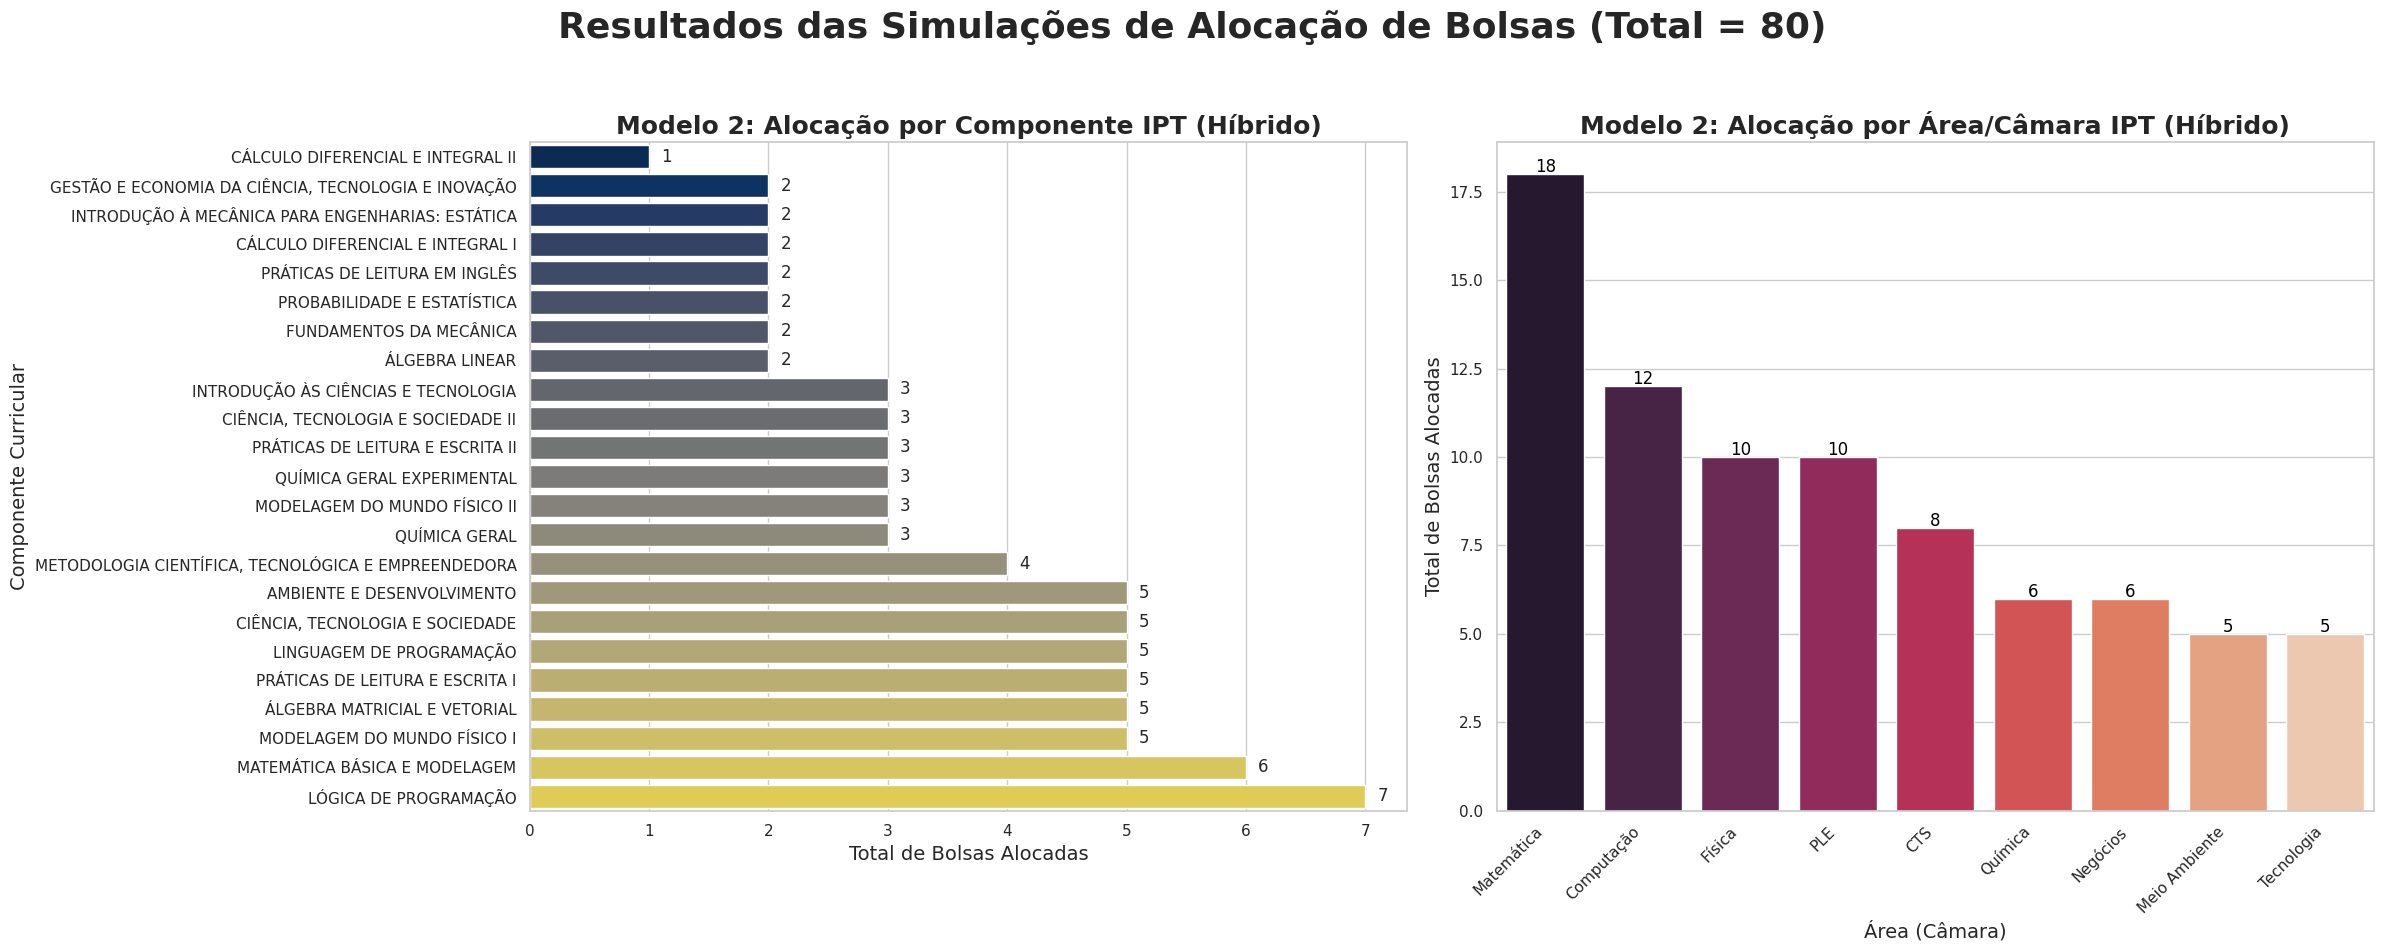

In [ ]:
#Execute para gerar os gráficos do resultado da simulação
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_theme(style="whitegrid")
plt.rcParams['font.size'] = 12

fig, axes = plt.subplots(1, 2, figsize=(24, 10))
fig.suptitle('Resultados das Simulações de Alocação de Bolsas (Total = 80)', fontsize=26, weight='bold')

# --- GRÁFICO 3: Alocação por Componente (Modelo Híbrido) ---
ax3 = axes[0]
df_plot3 = df_comp_practice[df_comp_practice['bolsas_total'] > 0].sort_values('bolsas_total', ascending=True)
sns.barplot(ax=ax3, data=df_plot3, y='titulo', x='bolsas_total', palette='cividis', hue='titulo', legend=False)
ax3.set_title('Modelo 2: Alocação por Componente IPT (Híbrido)', fontsize=18, weight='bold')
ax3.set_xlabel('Total de Bolsas Alocadas', fontsize=14)
ax3.set_ylabel('Componente Curricular', fontsize=14)
for p in ax3.patches:
    width = p.get_width()
    ax3.text(width + 0.1, p.get_y() + p.get_height() / 2, f'{int(width)}', va='center')

# --- GRÁFICO 4: Alocação por Área (Modelo Híbrido) ---
ax4 = axes[1]
df_plot4 = df_area_practice[df_area_practice['bolsas_total'] > 0].sort_values('bolsas_total', ascending=False)
sns.barplot(ax=ax4, data=df_plot4, x='titulo', y='bolsas_total', palette='rocket', hue='titulo', legend=False)
ax4.set_title('Modelo 2: Alocação por Área/Câmara IPT (Híbrido)', fontsize=18, weight='bold')
ax4.set_xlabel('Área (Câmara)', fontsize=14)
ax4.set_ylabel('Total de Bolsas Alocadas', fontsize=14)
for label in ax4.get_xticklabels():
    label.set_rotation(45)
    label.set_ha('right')
for p in ax4.patches:
    ax4.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()